## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Устинов Иван Ваимович

In [49]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import sys
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [39]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [4]:
images_train, labels_train = next(iter(train_loader))

In [5]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

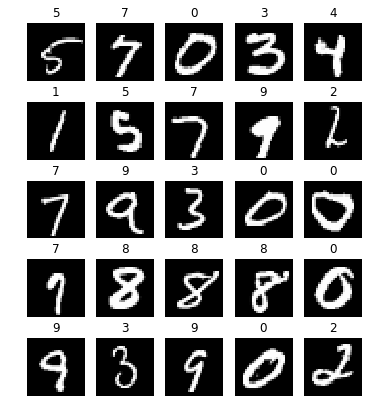

In [6]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [8]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().data #[0]
    print ('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().data #[0]
    print ('backward', std)

    
# пример:
layer = nn.Linear(28*28, 10)
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(backward_hook)
init_layer(layer, 0.0, 0.1) # сюда надо подставить другие параметры

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [10]:
def _linear_layer(input_size, output_size, init_layer):
    layer = nn.Linear(input_size, output_size)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_layer(layer)
    return layer

In [11]:
##### YOUR CODE HERE #####


#пример:
def check(init_layer, fun_activ):
    layers = []
    layers.append(_linear_layer(784, 500, init_layer))
    layers.append(fun_activ())
    for i in range(10):
        layers.append(_linear_layer(500, 500, init_layer))
        layers.append(fun_activ())
    layers.append(_linear_layer(500, 10, init_layer))
    layers.append(nn.LogSoftmax())
    network = nn.Sequential(*layers)
#     print(network)
    
    n_objects = 100
    X = Variable(images_train[:n_objects], requires_grad=False).view(n_objects, -1)
    y = Variable(labels_train[:n_objects], requires_grad=False)
    activations = network(X)
    loss_fn = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
    loss = loss_fn(activations, y)
    loss.backward()

In [14]:
check(init_layer, nn.Tanh)

forward tensor(0.9557)
forward tensor(0.9844)
forward tensor(0.9814)
forward tensor(0.9819)
forward tensor(0.9814)
forward tensor(0.9818)
forward tensor(0.9817)
forward tensor(0.9812)
forward tensor(0.9818)
forward tensor(0.9818)
forward tensor(0.9812)
forward tensor(0.9819)
backward tensor(0.0636)
backward tensor(0.0210)
backward tensor(0.0682)
backward tensor(0.2471)
backward tensor(0.8767)
backward tensor(2.9468)
backward tensor(10.8109)
backward tensor(38.2420)
backward tensor(117.8765)
backward tensor(450.8878)
backward tensor(1644.7058)
backward tensor(5257.5342)


Можно наблюдать взрывающийся градиент

<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [15]:
##### YOUR CODE HERE #####
def init_layer_Xavier(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    a = np.sqrt(6) / np.sqrt(weight.shape[0] + weight.shape[1])
    weight.uniform_(-a, a)
    
def init_layer_He(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=np.sqrt(2/weight.shape[1]))

#### Инициализация He функции ReLU и Tanh соответственно:

In [16]:
check(init_layer_He, nn.ReLU)

forward tensor(0.9557)
forward tensor(0.7794)
forward tensor(0.7827)
forward tensor(0.7999)
forward tensor(0.8118)
forward tensor(0.7944)
forward tensor(0.8185)
forward tensor(0.8135)
forward tensor(0.8239)
forward tensor(0.8116)
forward tensor(0.7635)
forward tensor(0.7958)
backward tensor(0.2364)
backward tensor(0.0296)
backward tensor(0.0263)
backward tensor(0.0241)
backward tensor(0.0248)
backward tensor(0.0231)
backward tensor(0.0233)
backward tensor(0.0199)
backward tensor(0.0174)
backward tensor(0.0165)
backward tensor(0.0149)
backward tensor(0.0117)


In [17]:
check(init_layer_He, nn.Tanh)

forward tensor(0.9557)
forward tensor(0.7044)
forward tensor(0.6241)
forward tensor(0.5904)
forward tensor(0.5727)
forward tensor(0.5688)
forward tensor(0.5614)
forward tensor(0.5624)
forward tensor(0.5587)
forward tensor(0.5533)
forward tensor(0.5550)
forward tensor(0.5503)
backward tensor(0.0483)
backward tensor(0.0067)
backward tensor(0.0069)
backward tensor(0.0073)
backward tensor(0.0076)
backward tensor(0.0071)
backward tensor(0.0072)
backward tensor(0.0071)
backward tensor(0.0072)
backward tensor(0.0075)
backward tensor(0.0074)
backward tensor(0.0064)


#### Инициализация Xavier функции ReLU и Tanh соответственно:

In [18]:
check(init_layer_Xavier, nn.ReLU)

forward tensor(0.9557)
forward tensor(0.6135)
forward tensor(0.4065)
forward tensor(0.2800)
forward tensor(0.2024)
forward tensor(0.1511)
forward tensor(0.0995)
forward tensor(0.0732)
forward tensor(0.0506)
forward tensor(0.0364)
forward tensor(0.0268)
forward tensor(0.0192)
backward tensor(0.0385)
backward tensor(0.0050)
backward tensor(0.0036)
backward tensor(0.0025)
backward tensor(0.0017)
backward tensor(0.0013)
backward tensor(0.0009)
backward tensor(0.0006)
backward tensor(0.0004)
backward tensor(0.0003)
backward tensor(0.0002)
backward tensor(0.0001)


In [19]:
check(init_layer_Xavier, nn.Tanh)

forward tensor(0.9557)
forward tensor(0.6421)
forward tensor(0.4932)
forward tensor(0.4118)
forward tensor(0.3635)
forward tensor(0.3269)
forward tensor(0.2965)
forward tensor(0.2737)
forward tensor(0.2559)
forward tensor(0.2390)
forward tensor(0.2259)
forward tensor(0.2148)
backward tensor(0.0376)
backward tensor(0.0069)
backward tensor(0.0067)
backward tensor(0.0061)
backward tensor(0.0056)
backward tensor(0.0049)
backward tensor(0.0044)
backward tensor(0.0042)
backward tensor(0.0035)
backward tensor(0.0032)
backward tensor(0.0027)
backward tensor(0.0019)


<i> 1.4 Сделайте выводы по первой части </i>

Вцелом более умная инициализация выглядит адекватнее на фоне наивной инициализации. И так же эмпирически проверено, что Xavier для ReLU не очень хорошо работает, т.к. градиенты всё же затухают. Но во всех остальных случаях инициализация показала хороший результат.

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [68]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p):
        super(DropConnect, self).__init__()
        self.weight = Variable(torch.Tensor(input_dim, output_dim).normal_(mean=0, std=0.01), requires_grad=True)
        self.bias = Variable(torch.Tensor(1, output_dim).zero_(), requires_grad=True)
        self.p = p

    def forward(self, x):
        if self.training:
            mask = torch.zeros(self.weight.size()) + (1-self.p)
            mask = torch.bernoulli(mask)
        else:
            mask = torch.ones(self.weight.size()) * p
        mask = Variable(mask, requires_grad=False)
        output = torch.mm(x, self.weight*mask) + self.bias ##### YOUR CODE HERE #####
        return output

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Dropout между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

In [64]:
dtype=torch.FloatTensor

def train(network, epochs, learning_rate, loss=nn.NLLLoss(), optim=torch.optim.Adam, conv=False):
    train_loss_epochs = []
    train_accuracy_epochs = []
    test_loss_epochs = []
    test_accuracy_epochs = []
    optimizer = optim(network.parameters(), lr=learning_rate)
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_dataloader:
                X = Variable(X)
                X = X.view(X.shape[0], -1).type(dtype)
                y = Variable(y)
                #y = y.view(y.shape[0], -1).type(dtype)
                
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                optimizer.zero_grad()
                loss_batch.backward()
                optimizer.step()
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
  
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []    
            for sample in test_dataloader:
                X = Variable(X)
                X = X.view(X.shape[0], -1).type(dtype)
                y = Variable(y)
                #y = y.view(y.shape[0], -1).type(dtype)
                
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
                
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
    except KeyboardInterrupt:
        pass
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_epochs, label='Train')
    plt.plot(test_loss_epochs, label='Test')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy_epochs, label='Train accuracy')
    plt.plot(test_accuracy_epochs, label='Test accuracy')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.show()
    #return test_loss_epochs

Epoch 9... (Train/Test) NLL: 0.589/0.563	Accuracy: 0.848/0.851

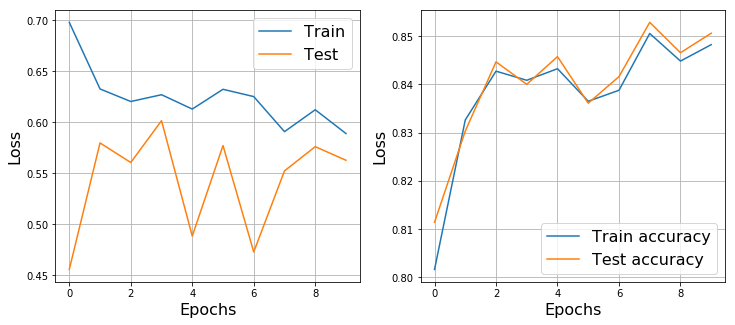

[0.4557768932626217,
 0.5797634720802307,
 0.5605565483057047,
 0.6015534008605571,
 0.4884679690946507,
 0.5771758835526961,
 0.4729030460496492,
 0.5523669365086133,
 0.5761055836949167,
 0.5627763633486591]

In [63]:
##### YOUR CODE HERE #####
network = nn.Sequential(nn.Linear(28*28, 200), 
                        nn.Dropout(0.5),
                        nn.ReLU(),
                        nn.Linear(200, 200),
                        nn.Dropout(0.5),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax())

train(network, 10, 1e-2)

Epoch 9... (Train/Test) NLL: 1.497/1.498	Accuracy: 0.525/0.524

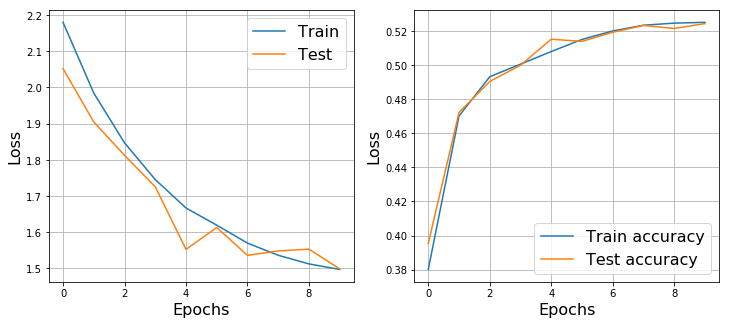

In [69]:
network = nn.Sequential(DropConnect(28*28, 200, 0.5),
                        nn.ReLU(),
                        DropConnect(200, 200, 0.5),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax())

train(network, 10, 1e-2)

<i> 2.3 Сделайте выводы по третьей части </i>

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [70]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        if x.shape[0] != 1:
            output = (x - mean) / std ##### YOUR CODE HERE #####
            return output
        else:
            return x

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Batch normalization между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

Epoch 9... (Train/Test) NLL: 0.023/0.026	Accuracy: 0.993/0.992

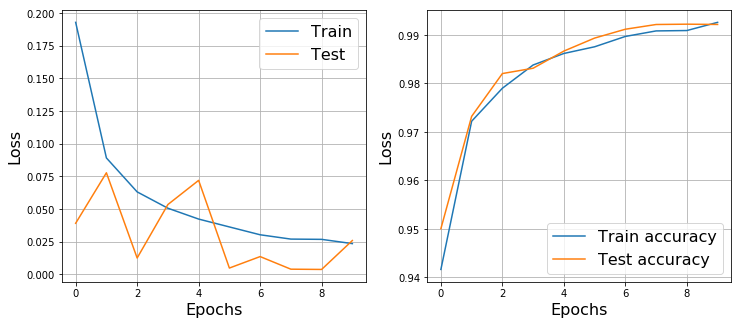

In [71]:
network = nn.Sequential(nn.Linear(28*28, 200), 
                        nn.BatchNorm1d(num_features=200),
                        nn.ReLU(),
                        nn.Linear(200, 200),
                        nn.BatchNorm1d(num_features=200),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax())

train(network, 10, 1e-2)

Epoch 9... (Train/Test) NLL: 0.027/0.003	Accuracy: 0.991/0.992

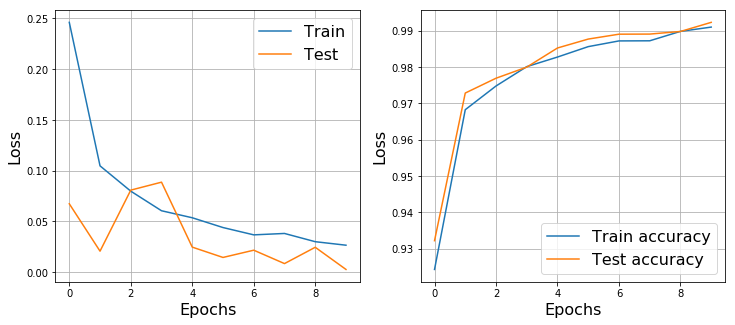

In [72]:
##### YOUR CODE HERE #####
network = nn.Sequential(nn.Linear(28*28, 200), 
                        LayerNormalization(),
                        nn.ReLU(),
                        nn.Linear(200, 200),
                        LayerNormalization(),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax())

train(network, 10, 1e-2)

<i> 3.3 Сделайте выводы по третьей части </i>

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: